In [65]:
from tensorflow.python.client import device_lib

import glob
import torch
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, ConvLSTM2D, Conv3D, Input
from tensorflow.keras import Model, layers, optimizers

import warnings
warnings.filterwarnings("ignore")

In [2]:
#GPU 사용 가능 여부 확인
device_lib.list_local_devices()

2021-11-11 01:12:52.585308: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 01:13:10.188212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 3079 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:1b:00.0, compute capability: 8.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4750966600008052892
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3229089792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16836196390017469208
 physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:1b:00.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2021-11-11 01:13:15.824434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 3079 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:1b:00.0, compute capability: 8.0


True

In [ ]:
#data load

In [4]:
#train데이터의 이름을 train_files라는 변수에 하나의 리스트로 넣음.
train_files = glob.glob('../radar_image_predict/data/train/*.npy')
len(train_files) #전체 데이터 개수 확인

62735

In [5]:
#data check

In [6]:
#1번째 데이터만 불러와서 데이터를 확인하자.
data_1st = np.load(train_files[0])
data_1st.shape

(120, 120, 5)

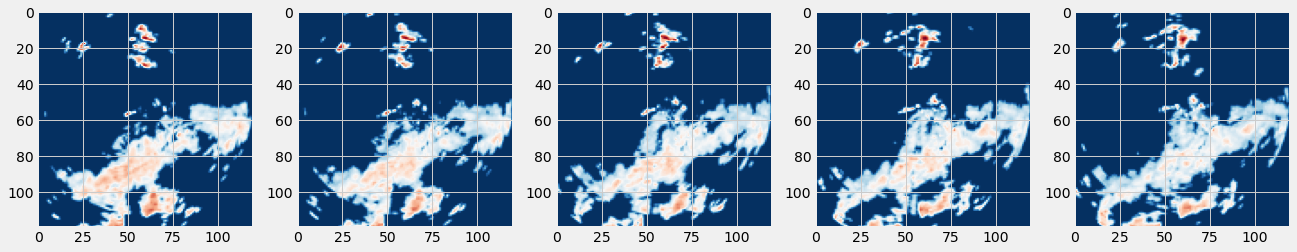

In [8]:
#data visualization
#color map 지정
color_map = plt.cm.get_cmap('RdBu')  #"RdBu"색으로 이미지를 칠함. 
color_map = color_map.reversed()  #지정된 색을 뒤집는다. 

#시각화
plt.style.use('fivethirtyeight')  #스타일 시트 지정.
plt.figure(figsize = (20,20)) #창의 크기를 (20, 20)으로 설정. 

for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(data_1st[:,:,i], cmap = color_map)

plt.subplot(1, 5, 5)
plt.imshow(data_1st[:,:,-1], cmap=color_map)
plt.show()


In [9]:
#data load & preprocessing

In [69]:
#data preprocessing
def trainGenerator():
    for file in train_files:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(None,10,120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)
        
        
train_data = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([None,10,120,120,4]),tf.TensorShape([None,10,120,120,1])))
train_dataset = train_data.batch(64).prefetch(1)
train_d = train_data

In [70]:
train_d

<FlatMapDataset shapes: ((None, 10, 120, 120, 4), (None, 10, 120, 120, 1)), types: (tf.float32, tf.float32)>

In [29]:
#modeling

In [71]:
#model
#inp = layers.Input(shape = (10,120,120,4))
def convlstm(input_layer, start_neurons):
    x = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(64, kernel_size=(5,5), padding = 'same', return_sequences = True, activation = 'relu',)(x)
    x = layers.BatchNormalization()(x)

    output_layer = layers.Conv3D(filters = 1, kernel_size = (5,5,5), activation = 'sigmoid', padding='same')(x)
    
    
input_layer = Input((10,120, 120, 4)) #input으로 들어오는 값이 None이라서 그런가?
output_layer = convlstm(input_layer,64)

In [67]:
model = keras.models.Model(inp,x)
model.compile(loss = 'mae', optimizer = 'adam')

In [68]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10, 120, 120, 4)] 0         
_________________________________________________________________
conv_lst_m2d_22 (ConvLSTM2D) (None, 10, 120, 120, 64)  435456    
_________________________________________________________________
batch_normalization_20 (Batc (None, 10, 120, 120, 64)  256       
_________________________________________________________________
conv_lst_m2d_23 (ConvLSTM2D) (None, 10, 120, 120, 64)  819456    
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 120, 120, 64)  256       
_________________________________________________________________
conv_lst_m2d_24 (ConvLSTM2D) (None, 10, 120, 120, 64)  819456    
_________________________________________________________________
batch_normalization_22 (Batc (None, 10, 120, 120, 64)  256 

In [72]:
with tf.device("/device:GPU:0"):
    model.fit(train_d, batch_size=4, epochs = 1, verbose=1)

2021-11-11 02:07:46.432717: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: TypeError: 'NoneType' object cannot be interpreted as an integer
Traceback (most recent call last):

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_4893/69340453.py", line 5, in trainGenerator
    target= dataset[:,:,-1].reshape(None,10,120,120,1)

TypeError: 'NoneType' object cannot be interpreted as an integer




InvalidArgumentError: 2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: 'NoneType' object cannot be interpreted as an integer
Traceback (most recent call last):

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_4893/69340453.py", line 5, in trainGenerator
    target= dataset[:,:,-1].reshape(None,10,120,120,1)

TypeError: 'NoneType' object cannot be interpreted as an integer


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[gradient_tape/mean_absolute_error/sub/Shape_1/_6]]
  (1) INVALID_ARGUMENT:  TypeError: 'NoneType' object cannot be interpreted as an integer
Traceback (most recent call last):

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/home/wm/anaconda/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_4893/69340453.py", line 5, in trainGenerator
    target= dataset[:,:,-1].reshape(None,10,120,120,1)

TypeError: 'NoneType' object cannot be interpreted as an integer


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_56159]

Function call stack:
train_function -> train_function
